In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from datetime import datetime

import sys
sys.path.append('../lib/')
from blood_lib import import_pbc, learning_curves

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

2023-06-06 12:55:19.963309: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.__version__

'2.12.0'

In [3]:
path = '../Data/PBC_6cat_masked/'

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    image_size=(128, 128),
    labels='inferred',
    interpolation='bicubic',
    label_mode='categorical',
    validation_split=0.20,
    batch_size=32,
    subset='both',
    shuffle=True,
    seed=1
)
class_names = train_ds.class_names
num_classes = len(class_names)
train_ds, test_ds = tf.keras.utils.split_dataset(train_ds, left_size=0.8, seed=1)
print('train batch :', tf.data.Dataset.cardinality(train_ds).numpy())
print('val batch :', tf.data.Dataset.cardinality(val_ds).numpy())
print('test batch :', tf.data.Dataset.cardinality(test_ds).numpy())
print('classes :', class_names)
print('num_classes :', num_classes)

Found 10868 files belonging to 6 classes.
Using 8695 files for training.
Using 2173 files for validation.
Metal device set to: AMD Radeon Pro 570

systemMemory: 40.00 GB
maxCacheSize: 2.00 GB



2023-06-06 12:55:26.206403: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-06 12:55:26.206509: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-06-06 12:55:26.684609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8695]
	 [[{{node Placeholder/_0}}]]
2023-06-06 12:55:26.685022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does 

train batch : 218
val batch : 68
test batch : 55
classes : ['basophil', 'eosinophil', 'erythroblast', 'lymphocyte', 'monocyte', 'platelet']
num_classes : 6


Calcul des class_weights

On veut "accorder plus d'attention" aux exemples d'une classe sous-représentée

In [4]:
directory = Path(path)
class_weights = {}
total = len(list(directory.glob('**/*.png')))
for i, class_name in enumerate(class_names):
    #print(i, class_name)
    len_i = len(list(Path(directory/class_name).glob('*.png')))
    print(i, len_i)
    weight_for_i = (1 / len_i) * (total / num_classes)
    #print(weight_for_i)
    class_weights[i] = weight_for_i
class_weights

0 1218
1 3117
2 1551
3 1214
4 1420
5 2348


{0: 1.4871373836891078,
 1: 0.5811143193241364,
 2: 1.1678486997635933,
 3: 1.4920373421197144,
 4: 1.275586854460094,
 5: 0.7714366837024418}

Remarque : L'utilisation de class_weights modifie la plage de perte. Cela peut affecter la stabilité de l'entraînement en fonction de l'optimiseur. Les optimiseurs dont la taille de pas dépend de l'ampleur du gradient, comme tf.keras.optimizers.SGD , peuvent échouer. L'optimiseur utilisé ici, tf.keras.optimizers.Adam , n'est pas affecté par le changement d'échelle. Notez également qu'en raison de la pondération, les pertes totales ne sont pas comparables entre les deux modèles.

In [5]:
# Random data augmentation
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(128, 128, 3)),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomBrightness(factor=0.001, value_range=(0,255)),
        tf.keras.layers.RandomContrast(factor=0.1)
    ])

def process_images(ds, shuffle=1000, augment=False):
    """
    Apply diverse images modification in a tf.data.Dataset
    """
    # rescale
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    ds = ds.map(lambda x, y: (normalization_layer(x), y))
    # shuffle
    if shuffle != None:
        ds = ds.shuffle(shuffle)
    # augment
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y))
    return ds

train_ds = process_images(train_ds, shuffle=100, augment=True)
val_ds = process_images(val_ds, shuffle=None, augment=False)
test_ds = process_images(test_ds, shuffle=None, augment=False)

2023-06-06 12:55:38.805513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [6956,128,128,3]
	 [[{{node Placeholder/_0}}]]
2023-06-06 12:55:38.806023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_17' with dtype resource
	 [[{{node Placeholder/_17}}]]
2023-06-06 12:55:38.932731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-06 12:55:39.676007: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:GPU:0] (DEBUG INFO) Executor start abortin

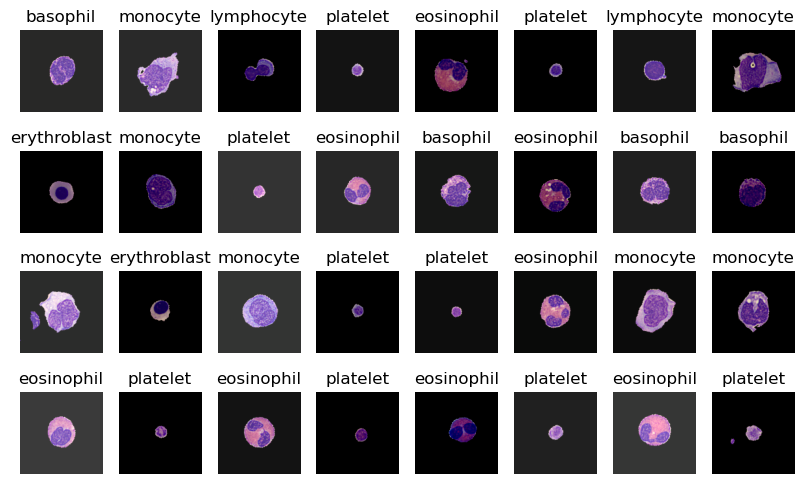

In [6]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10,6))
for i in range(32):
  ax = plt.subplot(4, 8, i + 1)
  plt.imshow(image_batch[i].numpy())
  plt.title(class_names[np.argmax(label_batch[i])])
  plt.axis("off")

In [7]:
import keras
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras import backend as K
from keras.applications.resnet import ResNet50

# Modèle VGG16
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3)) 

base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

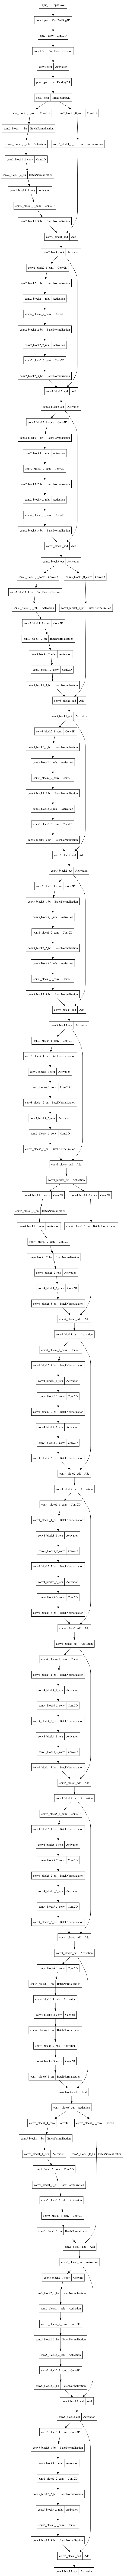

In [8]:
tf.keras.utils.plot_model(base_model)

In [14]:
for i, layer in enumerate(base_model.layers[143:]):
    print(i, layer.name, '-', layer.trainable)

0 conv5_block1_1_conv - True
1 conv5_block1_1_bn - True
2 conv5_block1_1_relu - True
3 conv5_block1_2_conv - True
4 conv5_block1_2_bn - True
5 conv5_block1_2_relu - True
6 conv5_block1_0_conv - True
7 conv5_block1_3_conv - True
8 conv5_block1_0_bn - True
9 conv5_block1_3_bn - True
10 conv5_block1_add - True
11 conv5_block1_out - True
12 conv5_block2_1_conv - True
13 conv5_block2_1_bn - True
14 conv5_block2_1_relu - True
15 conv5_block2_2_conv - True
16 conv5_block2_2_bn - True
17 conv5_block2_2_relu - True
18 conv5_block2_3_conv - True
19 conv5_block2_3_bn - True
20 conv5_block2_add - True
21 conv5_block2_out - True
22 conv5_block3_1_conv - True
23 conv5_block3_1_bn - True
24 conv5_block3_1_relu - True
25 conv5_block3_2_conv - True
26 conv5_block3_2_bn - True
27 conv5_block3_2_relu - True
28 conv5_block3_3_conv - True
29 conv5_block3_3_bn - True
30 conv5_block3_add - True
31 conv5_block3_out - True


In [16]:
for layer in base_model.layers[:143]:
    layer.trainable = False

model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(Flatten()) 
model.add(Dense(256,activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 32,018,118
Trainable params: 23,406,406


In [17]:
epochs=50
log_dir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             TensorBoard(log_dir=log_dir, histogram_freq=1),
             ModelCheckpoint(filepath="log_dir/Restnet50.h5",
                             monitor="val_loss",
                             mode='min',
                             save_best_only=True)]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weights
)

2023-05-21 11:40:50.973759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_17' with dtype resource
	 [[{{node Placeholder/_17}}]]
2023-05-21 11:40:50.974452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [6956,128,128,3]
	 [[{{node Placeholder/_0}}]]


Epoch 1/50
218/218 [==============================] - ETA: 0s - loss: 0.8118 - accuracy: 0.6902

2023-05-21 11:44:57.044626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2173]
	 [[{{node Placeholder/_4}}]]
2023-05-21 11:44:57.045064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2173]
	 [[{{node Placeholder/_4}}]]


218/218 [==============================] - 289s 1s/step - loss: 0.8118 - accuracy: 0.6902 - val_loss: 1.5051 - val_accuracy: 0.2844
Epoch 2/50
218/218 [==============================] - 275s 1s/step - loss: 0.6376 - accuracy: 0.7772 - val_loss: 0.7235 - val_accuracy: 0.7165
Epoch 3/50
218/218 [==============================] - 277s 1s/step - loss: 0.5757 - accuracy: 0.7959 - val_loss: 0.4486 - val_accuracy: 0.8394
Epoch 4/50
218/218 [==============================] - 280s 1s/step - loss: 0.5334 - accuracy: 0.8157 - val_loss: 0.4717 - val_accuracy: 0.8283
Epoch 5/50
218/218 [==============================] - 281s 1s/step - loss: 0.5128 - accuracy: 0.8283 - val_loss: 0.5148 - val_accuracy: 0.8159
Epoch 6/50
218/218 [==============================] - 290s 1s/step - loss: 0.4900 - accuracy: 0.8353 - val_loss: 0.4894 - val_accuracy: 0.8219
Epoch 7/50
218/218 [==============================] - 288s 1s/step - loss: 0.4458 - accuracy: 0.8498 - val_loss: 0.6333 - val_accuracy: 0.7492
Epoch 8/50

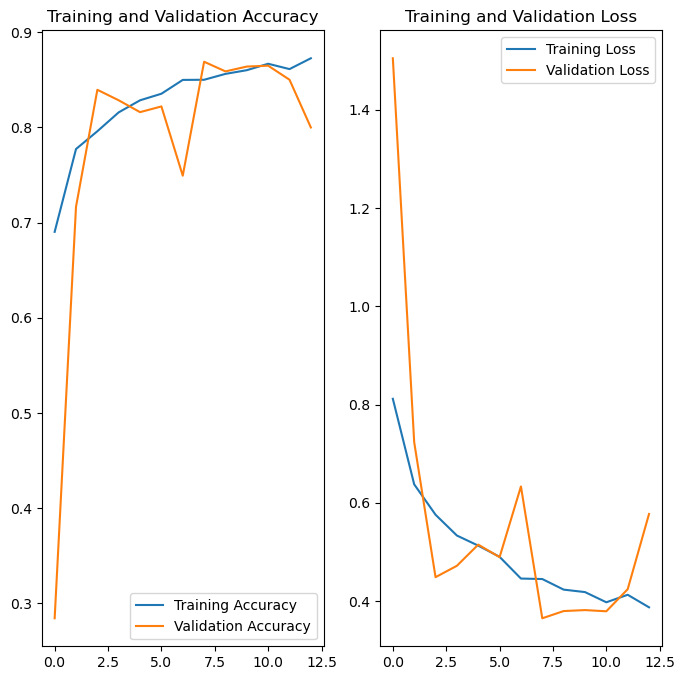

In [18]:
learning_curves(history)

In [19]:
model.save('../Models/ResNet_pt_6cat_4layers.h5')

In [20]:
ResNet = tf.keras.models.load_model('../Models/ResNet_pt_6cat_4layers.h5')

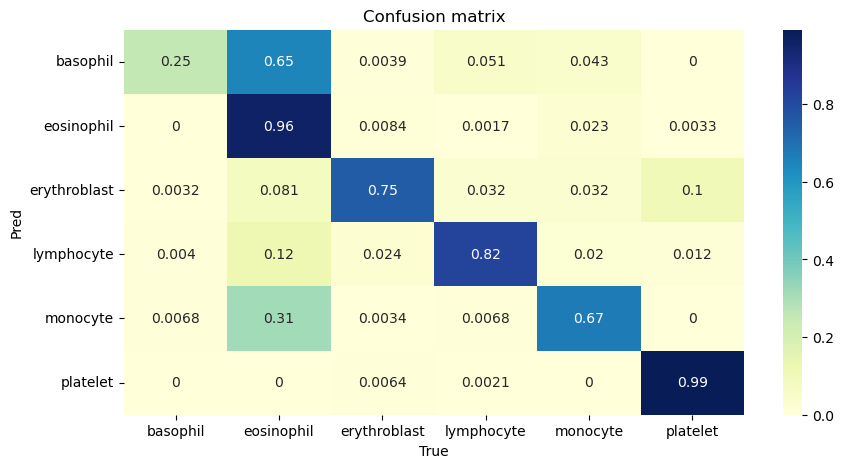

              precision    recall  f1-score   support

    basophil       0.94      0.25      0.40       256
  eosinophil       0.65      0.96      0.78       598
erythroblast       0.94      0.75      0.83       310
  lymphocyte       0.88      0.82      0.85       248
    monocyte       0.83      0.67      0.74       292
    platelet       0.93      0.99      0.96       469

    accuracy                           0.80      2173
   macro avg       0.86      0.74      0.76      2173
weighted avg       0.84      0.80      0.78      2173



In [21]:
preds = ResNet.predict(
        val_ds,
        batch_size=32,
        verbose=0
)
preds = np.argmax(preds, axis=1)
true = np.concatenate([y for x, y in val_ds], axis=0)
true = np.argmax(true, axis=1)
preds_labels = [class_names[preds[x]] for x in range(len(preds))]
true_labels = [class_names[true[x]] for x in range(len(true))]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, preds_labels, normalize='true')
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 5))
plt.title("Confusion matrix")
sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
plt.ylabel("Pred")
plt.xlabel("True")
plt.show()
print(classification_report(true_labels,preds_labels))

2023-05-21 13:18:52.275926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [1739,6]
	 [[{{node Placeholder/_1}}]]


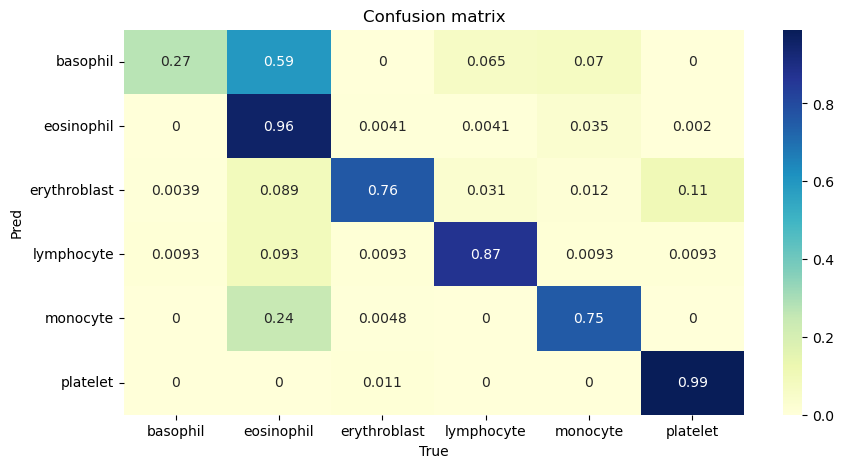

              precision    recall  f1-score   support

    basophil       0.94      0.27      0.42       186
  eosinophil       0.70      0.96      0.81       492
erythroblast       0.96      0.76      0.85       257
  lymphocyte       0.90      0.87      0.88       216
    monocyte       0.82      0.75      0.78       209
    platelet       0.93      0.99      0.96       379

    accuracy                           0.83      1739
   macro avg       0.87      0.77      0.78      1739
weighted avg       0.85      0.83      0.81      1739



In [22]:
preds = ResNet.predict(test_ds, batch_size=32, verbose=0)
preds = np.argmax(preds, axis=1)
true = np.concatenate([y for x, y in test_ds], axis=0)
true = np.argmax(true, axis=1)
preds_labels = [class_names[preds[x]] for x in range(len(preds))]
true_labels = [class_names[true[x]] for x in range(len(true))]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, preds_labels, normalize='true')
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 5))
plt.title("Confusion matrix")
sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
plt.ylabel("Pred")
plt.xlabel("True")
plt.show()
print(classification_report(true_labels,preds_labels))